# Homework Assignment 2
## Object Oriented Programming, Agent Based Modeling (ABM), and Graph Theory

### <p style="text-align: right;"> &#9989; Brandon Johnson.</p>
### <p style="text-align: right;"> &#9989; Put your _GitHub username_ here.</p>

<img src="https://cdn.motor1.com/images/mgl/6nkJZ/s1/the-2022-ford-f-150-lightning-electric-truck-charging-at-electrify-america-s-200th-charging-station-in-california-located-at-westfield-valley-fair-shopping-center-in-santa-clara..webp" width=600px align="top" style="margin-left: 5px" alt="Image credit: https://insideevs.com/news/567694/chargers-outnumber-gas-stations-soon/">


### Goals for this homework assignment
By the end of this assignment, you should be able to:
* Understand and implement agent objects.
* Run and modify agent based models.
* Create your own class using inheritance from a super class
* Use your Pandas skills to load the adjacency matrix, understand the graph properties, and visualize it using Networkx.
* Make changes to the edges in a graph.

Work through the following assignment, making sure to follow all of the directions and answer all of the questions.

There are **50 points** possible on this assignment. Point values for each part are included in the section headers and question prompts.

**This assignment is due in roughly two weeks from now at 11:59 pm on Friday, October 20.** It should be uploaded into the "Homework Assignments" submission folder for Homework #2.  Submission instructions can be found at the end of the notebook.

---
## Part 1: Add to your Git repository to track your progress on your assignment (2 points)

For this assignment, you're going to add it to the `cmse202-f23-turnin` repository you created in class so that you can track your progress on the assignment and preserve the final version that you turn in. In order to do this you need to

**&#9989; Do the following**:

1. Navigate to your `cmse202-f23-turnin` repository and create a new directory called `hw-02`.
2. Move this notebook into that **new directory** in your repository, then **add it and commit it to your repository**.
3. Finally, to test that everything is working, "git push" the file so that it ends up in your GitHub repository.

**Important**: Double check you've added your Professor and your TA as collaborators to your "turnin" repository (you should have done this in the previous homework assignment).

**Also important**: Make sure that the version of this notebook that you are working on is the same one that you just added to your repository! If you are working on a different copy of the notebook, **none of your changes will be tracked**!

If everything went as intended, the file should now show up on your GitHub account in the "`cmse202-f23-turnin`" repository inside the `hw-02` directory that you just created.  Periodically, **you'll be asked to commit your changes to the repository and push them to the remote GitHub location**. Of course, you can always commit your changes more often than that, if you wish.  It can be good to get into a habit of committing your changes any time you make a significant modification, or when you stop working on the project for a bit.

&#9989; **1.1 Do this**: Before you move on, put the command that your instructor should run to clone your repository in the markdown cell below.

<font size=6 color="#009600">&#9998;</font> git clone https://github.com/johnsonbj199/CMSE202-f23-turnin.git 

**You MUST commit and push your notebook multiple times during this assignment.**

---
## Part 2: Implement ABM of Installations of Electric Car Charging Stations(17 points)
<img src="https://www.olsun.com/wp-content/uploads/2020/11/electrical-vehicle-charging-systems-main.jpg" width=300px align="right" style="margin-left: 20px" alt="Image credit:https://www.olsun.com/capabilities/electric-car-vehicle-charging-station-manufacturer/">

To advance the adoption of electric vehicles around the country, there needs to be a concerted effort to install the infrastructure of electric car charging stations.  For this part of the assignment, you're going to implement an Agent Based Model of the installation of electric charging stations in a country.  The basic rules of this model are:

1. The country will be modeled as a square grid.
2. Installation teams try to install a charging station at each location in the grid; Once a charging station is installed it lasts forever.
3. At every increment of time, an installation team visits one random location in the grid and has a chance of succeeding at installing a station. Each install team has their own probability of success based on the skills+experience of the team. 
4. At each location in grid, sometimes the install teams fails to install a charging station because of various forces outside the control of the team such as inability to secure permits, necessary contracts, or local supplies.  Because of these forces outside the control of the team, each location in the grid has its own base probability of receiving a charging station. 
5. If a team fails to install a charging station at a location, it still makes a positive impact by improving the base probability of that location receiving a charging station in the future. 
6. Each time step in the model represents one month.


Execute the cell below to load python necessary packages.

In [14]:
## import the needed packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output 
import time
import random

Read through the following code that sets up this model and performs a simulation.  Then, answer the questions below.

In [15]:
# Create a class to represent agent based model of electric charging stations for cars
class ChargeLocationsWorld:
    def __init__(self, board_size=25, num_installers=5,num_initial_stations=10):
        self.board_size = board_size
        self.num_stations = num_initial_stations
        
        # initialize the map of stations
        self.charge_station_map = np.zeros([self.board_size,self.board_size])
        # create the initial stations
        self.place_initial_stations()

        # set up base probability of installing a station
        self.base_probability_map = np.zeros([self.board_size,self.board_size])
        self.set_base_probabilities()

        # create the installers
        self.installer_list = []
        experience_level = [0.5, 0.75, 1.0]  # to represent 3 levels of experience+success from low to high
        for i in range(num_installers):
            experience_now = experience_level[np.random.randint(0,3)]
            self.installer_list.append(InstallTeam(experience_now))


    def place_initial_stations(self):
        # loop over the number of initial stations
        for s in range(self.num_stations):
            # pick a random location
            (x,y) = (np.random.randint(0,self.board_size), np.random.randint(0,self.board_size))
            # set the location to 1 to represent a station
            self.charge_station_map[x,y] = 1

    def set_base_probabilities(self):
        # set base probability of each location having a successful install
        mu=0.5
        sigma=0.2
        # loop over the board
        for x in range(self.board_size):
            for y in range(self.board_size):
                # set the probability at each location
                self.base_probability_map[x,y] = np.abs(sigma*np.random.randn()+mu)

    def improve_base_probability(self, x,y):
        # improve the base probability at a location
        self.base_probability_map[x,y] = self.base_probability_map[x,y]*1.3
        

    def return_empty_locations(self):
        # return a list of the locations that are empty
        empty_locations = []
        for x in range(self.board_size):
            for y in range(self.board_size):
                if self.charge_station_map[x,y] == 0:
                    empty_locations.append([x,y])
        return empty_locations

    def plot_world(self):
        # Create a figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        map_display = np.copy(self.charge_station_map)
        # loop over the installers and add their locations
        for installer in self.installer_list:
            map_display[installer.current_location[0],installer.current_location[1]] = 2

        # Display the first plot on the left subplot with the "hot" colormap
        ax1.imshow(map_display, cmap='hot')
        ax1.set_title('Installed Stations')

        # Display the second plot on the right subplot with the "hot" colormap
        im = ax2.imshow(self.base_probability_map, cmap='jet')
        ax2.set_title('Base Probability of Install')
        # Add a colorbar to the right plot
        cbar = fig.colorbar(im, ax=ax2)
        cbar.set_label('Probability of Install')
        # Adjust spacing between subplots
        plt.tight_layout()

        # Show the plots
        plt.show()

# Class to represent an install team
class InstallTeam:
    def __init__(self, install_skill_prob):
        self.install_skill_prob = install_skill_prob
        self.current_location=[0,0]

    def set_location(self, x,y):
        self.current_location = [x,y]

    def attempt_install(self,prob_success):
        
        # modify with effectiveness/experience of installer
        prob_success = prob_success*self.install_skill_prob

        # get a random number for success of install
        rand_num = np.random.rand()
        # check if the install was successful, 
        if rand_num < prob_success:  # Fixed on 10/6/2023 from original version, that had typo ">", see slack message in help 
            return True
        else:
            return False


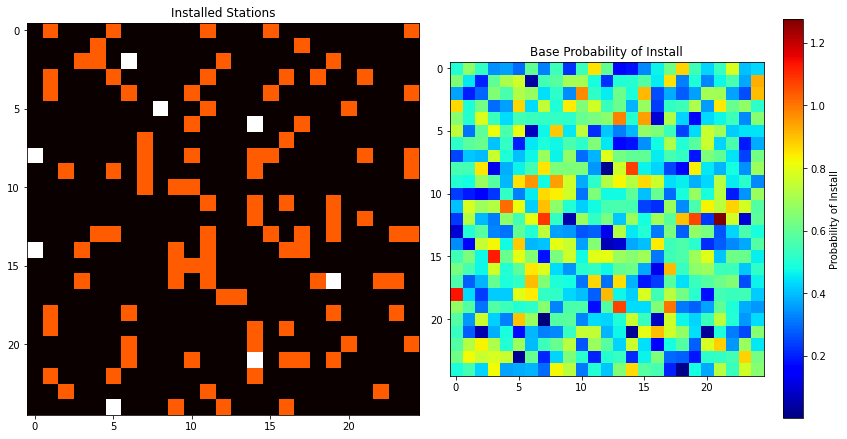

In [16]:
# Perform simulation of installers installing electric charging stations
world_object = ChargeLocationsWorld(25,8)

# loop over months
for tstep in range(25):
    # loop over installers
    for installer_now in world_object.installer_list:
        # pick a random location that does not have a station
        empty_locations = world_object.return_empty_locations()
        (x,y) = empty_locations[np.random.randint(0,len(empty_locations))]
        
        # set the location for the installer for this time step
        installer_now.set_location(x,y)
        # attempt to install a station at this location
        success = installer_now.attempt_install(world_object.base_probability_map[x,y])
        # if successful, add a station; else improve base probability
        if success:
            world_object.charge_station_map[x,y] = 1
        else:
            world_object.improve_base_probability(x,y)
    # plot the world
    world_object.plot_world()
    clear_output(wait=True) # Clear output for dynamic display


&#9989; **Question 2.1 (1 points)**: Using the simulation and code above, what do the orange and white colors in the left plot represent?

<font size=6 color="#009600">&#9998;</font> Orange are installed stations, white are places chosen to install that failed but as a result increased chance of success 


&#9989; **Question 2.2 (1 points)**: What is being represented in the right plot as time progresses?

<font size=6 color="#009600">&#9998;</font>The probability of installing in different locations as time continues, it updates over time as each time a team tries and fails an installation the probability of succesful installation increases so this grid updates over time as each action by the installation team effects the probability of success.


&#9989; **Question 2.3 (1 points)**: For the original code above, how many install teams are there in the simulation?

<font size=6 color="#009600">&#9998;</font> 5 installers


&#9989; **Question 2.4 (4 points)**: Approximately how long will it take (how many months) to install charging stations in 15% of the locations in the country?

Write code below that uses this model to answer this question.  (Note: you will need to copy simulation code from above to identify this; use a `print()` statement to display result; your results will likely vary slightly each time you run this.)

In [19]:
# Put your code here to run the simulation and see results
# Perform simulation of installers installing electric charging stations
world_object = ChargeLocationsWorld(25,8)

locations1 = int(world_object.board_size ** 2 * 0.15)
locations2 = np.sum(world_object.charge_station_map)
months = 0

while locations2 < locations1:
# loop over months
    for installer_now in world_object.installer_list:
        # pick a random location that does not have a station
        empty_locations = world_object.return_empty_locations()
        (x,y) = empty_locations[np.random.randint(0,len(empty_locations))]

        # set the location for the installer for this time step
        installer_now.set_location(x,y)
        # attempt to install a station at this location
        success = installer_now.attempt_install(world_object.base_probability_map[x,y])
        # if successful, add a station; else improve base probability
        if success:
            world_object.charge_station_map[x,y] = 1
            locations += 1
        else:
            world_object.improve_base_probability(x,y)
    
    # plot the world
    world_object.plot_world()
    clear_output(wait=True) # Clear output for dynamic display

    locations2 = np.sum(world_object.charge_station_map)
    months+= 1
    
print (months)

23


&#9989; **Question 2.5 (6 points)**: The electric vehicle companies think the install process is taking too long.  They recruited three superb install teams from a neighboring country.  These install teams have twice the experience (twice the success rates) as the current highly experienced install teams you are using.

Modify the code to include the addition of three superb install teams and rerun the simulation.  Also, modify the code to change the left display plot to include a different color for the original teams and the superb teams.

To do this, create a class definition that inherits all of the properties from the `ChargeLocationsWorld` class, and also adds these superb installers and performs a slighly different `plot_world`.  (Hint: one way to do this is to add a new list of superb installers in the contruction of this child class and add a new method to this child class to plot the world with different colors for regular vs superb installers) 

(Note: Any solution that uses class inheritance is acceptable)

When successful, you simulation should look something like this:

<img width=500px src="https://raw.githubusercontent.com/msu-cmse-courses/cmse202-supplemental-data/main/HW/Homework_2_FS23/suberb_installers.gif">

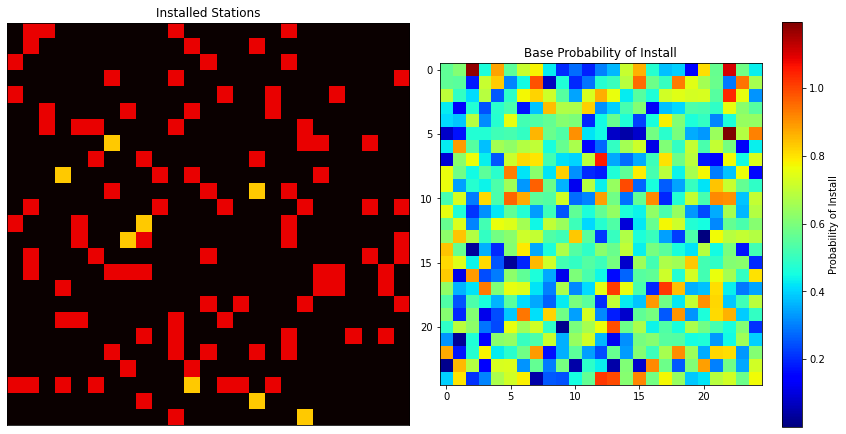

In [43]:


class SuperChargeLocationsWorld(ChargeLocationsWorld):
    def __init__(self, board_size=25, num_installers=5, num_super_installers=3, num_initial_stations=10 ):
        super().__init__(board_size, num_installers, num_initial_stations)
        self.super_installer_list = []

    def plot_world(self):
        
        # Create a figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        map_display = np.copy(self.charge_station_map)
        # loop over the regular installers and add their locations
        for installer in self.installer_list:
            map_display[installer.current_location[0], installer.current_location[1]] = 2

        for super_installer in self.super_installer_list:
            map_display[super_installer.current_location[0], super_installer.current_location[1]] = 3

        # Display the first plot on the left subplot with the "hot" colormap and additional colors
        ax1.imshow(map_display, cmap='hot', vmin=0, vmax=3)
        ax1.set_title('Installed Stations')
        ax1.set_yticks([])
        ax1.set_xticks([])

        # Display the second plot on the right subplot with the "hot" colormap
        im = ax2.imshow(self.base_probability_map, cmap='jet')
        ax2.set_title('Base Probability of Install')
        # Add a colorbar to the right plot
        cbar = fig.colorbar(im, ax=ax2)
        cbar.set_label('Probability of Install')
        # Adjust spacing between subplots
        plt.tight_layout()

        # Show the plots
        plt.show()


world_object = SuperChargeLocationsWorld(25,8,1)

# loop over months
for tstep in range(25):
    # loop over installers
    for installer_now in world_object.installer_list:
        # pick a random location that does not have a station
        empty_locations = world_object.return_empty_locations()
        (x,y) = empty_locations[np.random.randint(0,len(empty_locations))]
        
        # set the location for the installer for this time step
        installer_now.set_location(x,y)
        # attempt to install a station at this location
        success = installer_now.attempt_install(world_object.base_probability_map[x,y])
        # if successful, add a station; else improve base probability
        if success:
            world_object.charge_station_map[x,y] = 1
        else:
            world_object.improve_base_probability(x,y)
    # plot the world
    world_object.plot_world()
    clear_output(wait=True) # Clear output for dynamic display


&#9989; **Question 2.6 (4 points)**: This model is an approximation of a real phenomena.  What are two real-life changes that could be implemented to increase the rate of charging station installs and lead to full coverage of the country faster?  How could these two changes be implemented in your model?

<font size=6 color="#009600">&#9998;</font> Your answer here: (complete answers are required for full credit)

Change 1:

Change 1 Implementation in computational model:

Change 2:

Change 2 Implementation in computational model:


---
### &#128721; STOP
**Pause to commit your changes to your Git repository!**

Take a moment to save your notebook, commit the changes to your Git repository using the commit message "Committing Part 2", and push the changes to GitHub.

---

## Part 3: Graph representation and analysis for the Electric Power Grid (31 points)

Execute the cell below to load python necessary packages.

In [4]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
import time

<img src="https://www.sciencenews.org/wp-content/uploads/2023/08/082623_electical-grid_feat.jpg" width=400px align="top" style="margin-left: 5px" alt="Image credit: https://www.sciencenews.org/article/one-device-transform-power-electical-grid-inverter">


Electricity throughout the United States is provided by a large number of power plants that are interconnected by the power grid.  

Information on all of the US power plants is available in this data file:
`https://raw.githubusercontent.com/msu-cmse-courses/cmse202-supplemental-data/main/HW/Homework_2_FS23/global_power_plant_database_USA.csv`

This is a subset of a data set of all the power plants in the world available.  For those interested, the full dataset is available here: https://datasets.wri.org/dataset/globalpowerplantdatabase  (we won't need the full dataset)

If you'd like to learn more about  global electrical power supply, here is a great tool: https://resourcewatch.org/data/explore/Powerwatch


&#9989; **Question 3.1 (2 points)** Download this US data set and load into a pandas dataframe.  (provide code to download and load below)

In [5]:
# Put your code here:
# curl -O https://raw.githubusercontent.com/msu-cmse-courses/cmse202-supplemental-data/main/HW/Homework_2_FS23/global_power_plant_database_USA.csv
pp_df = pd.read_csv('global_power_plant_database_USA.csv')
pp_df

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017
0,USA,United States of America,100 Brook Hill Drive Solar,USA0063292,2.0,41.0930,-73.9828,Solar,NaN,NaN,...,NaN,NaN,NaN,NaN,3.25,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
1,USA,United States of America,1025 Traveller Solar LLC,USA0062660,5.0,35.4273,-79.1263,Solar,NaN,NaN,...,NaN,NaN,NaN,NaN,8.14,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
2,USA,United States of America,1047 Little Mountain Solar LLC,USA0062661,3.0,36.1971,-80.8067,Solar,NaN,NaN,...,NaN,NaN,NaN,NaN,4.88,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
3,USA,United States of America,12 Applegate Solar LLC,USA0059371,1.9,40.2003,-74.5761,Solar,NaN,NaN,...,2.92,2.94,3.06,2.85,2.61,SOLAR-V1,SOLAR-V1,SOLAR-V1,SOLAR-V1,SOLAR-V1
4,USA,United States of America,126 Grove Solar LLC,USA0060858,2.0,42.0761,-71.4227,Solar,NaN,NaN,...,3.01,2.98,3.11,2.98,2.64,SOLAR-V1,SOLAR-V1,SOLAR-V1,SOLAR-V1,SOLAR-V1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9828,USA,United States of America,Zion Landfill Gas to Energy Facility,USA0056871,7.0,42.4803,-87.8861,Waste,NaN,NaN,...,NaN,NaN,NaN,NaN,1.26,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
9829,USA,United States of America,Zorn,USA0001368,18.0,38.2803,-85.7023,Gas,NaN,NaN,...,NaN,NaN,NaN,NaN,63.47,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
9830,USA,United States of America,Zotos International WPGF,USA0057648,3.4,42.8869,-76.9683,Wind,NaN,NaN,...,8.31,8.46,6.57,6.52,6.81,WIND-V1,WIND-V1,WIND-V1,WIND-V1,WIND-V1
9831,USA,United States of America,Zumbro Community Solar Garden,USA0061574,1.0,44.3195,-92.6703,Solar,NaN,NaN,...,NaN,NaN,NaN,NaN,1.62,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1


&#9989; **Question 3.2 (3 points)** We would like to identify all of the power plants in the lower peninsula of Michigan State (this is the land region of Michigan that does not include the upper peninsula).  Make a pandas dataframe of just the plants in the lower peninsula of Michigan.  

(note: answers are acceptable if you are reasonably close to the correct set of power plants)



In [9]:
# Put your code here:
michigan_polygon = [[-83.454238,41.732339],[-84.807042,41.694001],[-84.807042,41.759724],[-85.990061,41.759724],[-86.822556,41.759724],[-86.619909,41.891171],[-86.482986,42.115725],[-86.357016,42.252649],[-86.263908,42.444341],[-86.209139,42.718189],[-86.231047,43.013943],[-86.526801,43.594499],[-86.433693,43.813577],[-86.499417,44.07647],[-86.269385,44.34484],[-86.220093,44.569394],[-86.252954,44.689887],[-86.088646,44.73918],[-86.066738,44.903488],[-85.809322,44.947303],[-85.612152,45.128042],[-85.628583,44.766564],[-85.524521,44.750133],[-85.393075,44.930872],[-85.387598,45.237581],[-85.305444,45.314258],[-85.031597,45.363551],[-85.119228,45.577151],[-84.938489,45.75789],[-84.713934,45.768844],[-84.461995,45.653829],[-84.215533,45.637398],[-84.09504,45.494997],[-83.908824,45.484043],[-83.596638,45.352597],[-83.4871,45.358074],[-83.317314,45.144473],[-83.454238,45.029457],[-83.322791,44.88158],[-83.273499,44.711795],[-83.333745,44.339363],[-83.536392,44.246255],[-83.585684,44.054562],[-83.82667,43.988839],[-83.958116,43.758807],[-83.908824,43.671176],[-83.667839,43.589022],[-83.481623,43.714992],[-83.262545,43.972408],[-82.917498,44.070993],[-82.747713,43.994316],[-82.643651,43.851915],[-82.539589,43.435668],[-82.523158,43.227544],[-82.413619,42.975605],[-82.517681,42.614127],[-82.681989,42.559357],[-82.687466,42.690804],[-82.797005,42.652465],[-82.922975,42.351234],[-83.125621,42.236218],[-83.185868,42.006186],[-83.437807,41.814493],[-83.454238,41.732339]]
# Extract the longitude and latitude coordinates from the polygon
lon, lat = zip(*michigan_polygon)
min_lon,max_lon = min(lon),max(lon)
min_lat,max_lat = min(lat),max(lat)
pp_df_lower_peninsula = pp_df.loc[((pp_df["latitude"]>=min_lat) & (pp_df["latitude"]<=max_lat) & (pp_df["longitude"]>=min_lon) & (pp_df["longitude"]<=max_lon)), ]
pp_df_lower_peninsula


,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017
30,USA,United States of America,491 E 48th Street,USA0007268,161.7,42.7553,-86.0853,Gas,Oil,NaN,...,NaN,NaN,NaN,NaN,570.23,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
125,USA,United States of America,Ada Cogeneration LP,USA0010819,33.1,42.9627,-85.4941,Gas,NaN,NaN,...,NaN,NaN,NaN,NaN,116.72,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
126,USA,United States of America,Ada Dam,USA0050433,1.4,42.9506,-85.4859,Hydro,NaN,NaN,...,4.98,5.54,4.89,5.44,5.07,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
147,USA,United States of America,Adrian Energy Associates LLC,USA0054903,2.4,41.8910,-83.9929,Waste,NaN,NaN,...,NaN,NaN,NaN,NaN,0.43,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
199,USA,United States of America,Alcona,USA0001693,8.0,44.5620,-83.8045,Hydro,NaN,NaN,...,31.77,33.48,25.04,32.43,30.60,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9711,USA,United States of America,Wood Road,USA0054549,8.0,42.7729,-84.5237,Waste,NaN,NaN,...,NaN,NaN,NaN,NaN,1.44,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
9756,USA,United States of America,Wyandotte,USA0001866,78.4,42.2081,-83.1453,Gas,Oil,NaN,...,NaN,NaN,NaN,NaN,276.47,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
9821,USA,United States of America,Zeeland,USA0001867,22.3,42.8067,-86.0558,Gas,Oil,NaN,...,NaN,NaN,NaN,NaN,78.64,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1
9822,USA,United States of America,Zeeland Farm Services,USA0058704,3.2,42.8131,-85.9861,Biomass,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION


&#9989; **Question 3.3 (1 points)** Based on this data, what is the total number of power plants in the lower peninsula of Michigan?
(note: answers are acceptable if you are reasonably close within 15 plants of the correct number)

<font size=6 color="#009600">&#9998;</font> 203 power plants

&#9989; **Question 3.4 (3 points)** The following code displays the outline of the lower peninsula of Michigan.  Add to this code to display the location of all of the Michigan power plants.  


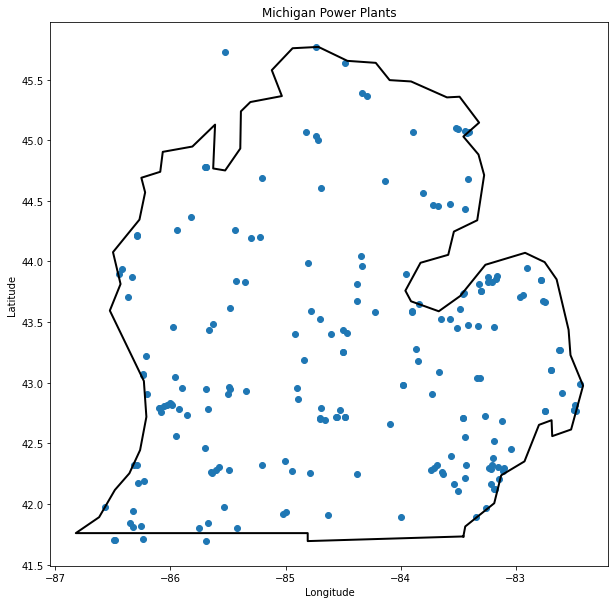

In [11]:
# make map of michigan power plants using matplotlib

import matplotlib.pyplot as plt

# Create a map centered on the mean latitude and longitude values

michigan_map = plt.figure(figsize=(10,10))
michigan_polygon = [[-83.454238,41.732339],[-84.807042,41.694001],[-84.807042,41.759724],[-85.990061,41.759724],[-86.822556,41.759724],[-86.619909,41.891171],[-86.482986,42.115725],[-86.357016,42.252649],[-86.263908,42.444341],[-86.209139,42.718189],[-86.231047,43.013943],[-86.526801,43.594499],[-86.433693,43.813577],[-86.499417,44.07647],[-86.269385,44.34484],[-86.220093,44.569394],[-86.252954,44.689887],[-86.088646,44.73918],[-86.066738,44.903488],[-85.809322,44.947303],[-85.612152,45.128042],[-85.628583,44.766564],[-85.524521,44.750133],[-85.393075,44.930872],[-85.387598,45.237581],[-85.305444,45.314258],[-85.031597,45.363551],[-85.119228,45.577151],[-84.938489,45.75789],[-84.713934,45.768844],[-84.461995,45.653829],[-84.215533,45.637398],[-84.09504,45.494997],[-83.908824,45.484043],[-83.596638,45.352597],[-83.4871,45.358074],[-83.317314,45.144473],[-83.454238,45.029457],[-83.322791,44.88158],[-83.273499,44.711795],[-83.333745,44.339363],[-83.536392,44.246255],[-83.585684,44.054562],[-83.82667,43.988839],[-83.958116,43.758807],[-83.908824,43.671176],[-83.667839,43.589022],[-83.481623,43.714992],[-83.262545,43.972408],[-82.917498,44.070993],[-82.747713,43.994316],[-82.643651,43.851915],[-82.539589,43.435668],[-82.523158,43.227544],[-82.413619,42.975605],[-82.517681,42.614127],[-82.681989,42.559357],[-82.687466,42.690804],[-82.797005,42.652465],[-82.922975,42.351234],[-83.125621,42.236218],[-83.185868,42.006186],[-83.437807,41.814493],[-83.454238,41.732339]]
# Extract the longitude and latitude coordinates from the polygon
lon, lat = zip(*michigan_polygon)


# Plot the Michigan state outline `lon` and `lat` coordinates as a black line
plt.plot(lon, lat, color='black', linewidth=2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Michigan Power Plants')



# Put your code here to display the locations of the power plants in Michigan:
plt.scatter(pp_df_lower_peninsula["longitude"],pp_df_lower_peninsula["latitude"])



plt.show()

&#9989; **Question 3.5 (4 points)** Consumers Energy (https://www.consumersenergy.com/) is the power company that serves central Michigan, including the East Lansing area.  Recreate your map above, with the power plants that are run by Consumers Energy highlighted in a larger marker with a different color.

(Hint: The data set includes information on the owner of each plant)


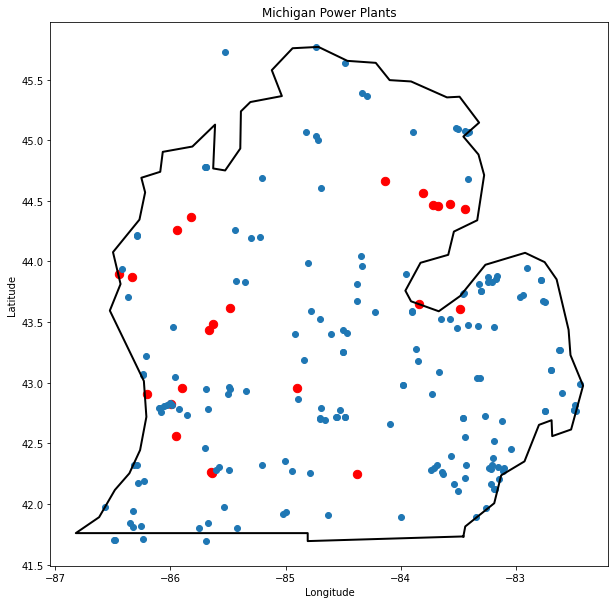

In [12]:
# Put your code here:
pp_df_lower_peninsula["longitude"],pp_df_lower_peninsula["latitude"]
long1_lst = pp_df_lower_peninsula.loc[(pp_df_lower_peninsula["owner"] == "Consumers Energy Co"),"longitude"]
lat1_lst = pp_df_lower_peninsula.loc[(pp_df_lower_peninsula["owner"] == "Consumers Energy Co"),"latitude"]
long2_lst = pp_df_lower_peninsula.loc[~(pp_df_lower_peninsula["owner"] == "Consumers Energy Co"),"longitude"]
lat2_lst = pp_df_lower_peninsula.loc[~(pp_df_lower_peninsula["owner"] == "Consumers Energy Co"),"latitude"]
# Plot the Michigan state outline `lon` and `lat` coordinates as a black line
michigan_map = plt.figure(figsize=(10,10))
plt.plot(lon, lat, color='black', linewidth=2)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Michigan Power Plants')


# Put your code here to display the locations of the power plants in Michigan:
plt.scatter(long1_lst,lat1_lst, c= "red",s =70)
plt.scatter(long2_lst,lat2_lst)


plt.show()

### Graph representation of Consumer Energy power plants

&#9989; **Question 3.6 (3 points)** 

We can present a connected grid of power plants with a graph.  Each node represents a power plant and each edge represent power lines that connect the plants.

Let's first construct the network (graph). The adjacency matrix, which tells us which nodes are connected with each other, is provided in the file `consumers_adjacency_matrix.csv`. The locations of the plants are provided in `consumers_locations.csv`.  Please note that the provided adjacency matrix is a hypothetical connection of plants just for this assignment, while the locations are real-world longitude and latitude of actual plants.  

**To Do:**
1. Load the data from `consumers_adjacency_matrix.csv` and `consumers_locations.csv` using Pandas, and then construct the graph using Networkx. 

2. Visualize the graph after it's constructed, with node labels shown on the graph. 


Location of data files:

`https://raw.githubusercontent.com/msu-cmse-courses/cmse202-supplemental-data/main/HW/Homework_2_FS23/consumers_adjacency_matrix.csv`

`https://raw.githubusercontent.com/msu-cmse-courses/cmse202-supplemental-data/main/HW/Homework_2_FS23/consumers_locations.csv`


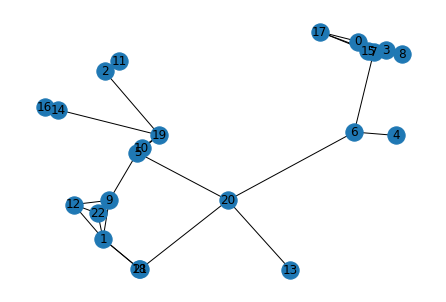

In [14]:
# Complete the following code to construct and display the graph
position_df = pd.read_csv('https://raw.githubusercontent.com/msu-cmse-courses/cmse202-supplemental-data/main/HW/Homework_2_FS23/consumers_locations.csv', header=None)
graph_adjacency_df = pd.read_csv('https://raw.githubusercontent.com/msu-cmse-courses/cmse202-supplemental-data/main/HW/Homework_2_FS23/consumers_adjacency_matrix.csv',header=None)

position_df.reset_index(inplace=True)
#graph_adjacency_df.drop(columns=graph_adjacency_df.columns[0], axis=1, inplace=True)
graph_adjacency_matrix = graph_adjacency_df.to_numpy()
position_df.columns = ["node","lon","lat"]
position = {
    k: tuple(v.values()) 
    for k, v 
    in position_df.set_index('node').to_dict('index').items()
}
G = nx.Graph(graph_adjacency_matrix)
nx.draw(G, pos=position, with_labels=True)

&#9989; **Question 3.7 (4 points)** A stable power grid will have many connections (edges) between plants to ensure there are multiple redudancies in the power grid.  Redundancies are necessary in case a power line fails.

In the constructed network, you may notice some nodes have many more neighbors than other nodes, i.e. some nodes have more edges than other nodes. The number of edges connected to a specific node is called the **degree** of that node. A graph object created by Networkx has an attribute for degree of all the nodes. 

Get the degrees for all the nodes in the graph, and then plot a histogram to show the distribution of degrees.)

In [ ]:
# Put your code here:

&#9989; **Question 3.8 (4 points)** The Networkx `Graph()` method will support an input that is an adjacency matrix or a dictionary of edges cataloging the connections for each node.  In the example above, we provided an adjacency matrix.  Write a function to convert the provided adjacency matrix above to a dictionary of edges.  Then, construct the network with this dictionary of edges and display the network (the network will look identical as above, but with a different argument to the Graph() method)

For example, write code to take something like this
```# Simple adjacency matrix example
adj_matrix = [
    [0, 1, 1, 1, 1],
    [1, 0, 1, 0, 1],
    [0, 1, 0, 1, 0],
    [0, 0, 1, 0, 1],
    [1, 1, 0, 1, 0]
]
```

And generate a dictionary like this, where each key is a node # and its values are a list of the node #'s that are connected to it:

```edges_dict={0: [1, 2, 3, 4], 1: [0, 2, 4], 2: [1, 3], 3: [2, 4], 4: [0, 1, 3]}```



In [ ]:
# Put your code here:

&#9989; **Question 3.9 (3 point)** For the purposes of this assignment, let's say that plants with 3 or fewer power lines to other power plants are sub-optimal plants and are causing the power grid to be vulnerable.  Write code to analyze the adjacency matrix or edge dictionary to determine how many plants have 3 or less connections?

And, make a graph display that highlights the sub-optimal plants with a different color from the optimal plants.

In [ ]:
# Put your code here:


&#9989; **Question 3.10 (2 point)** Isomorphic graphs have the same number of vertices, edges, and also the same edge connectivity.  Below, write code to display a figure with 3 side-by-side graphs, where each graph is a different isomorphic display of the graph presented above.

In [ ]:
# Put your code here:


&#9989; **Question 3.11 (4 points)** You have been contracted to come up with a plan for increasing the connections to the the sub-optimal plants.  Write code to identify these plants and add power lines connecting these plants.  Once complete, recreate your graph and display it with the new power lines. 


NOT NECESSARY: If you would like a challenge, for extra credit, can you enforce the following optimizations
* (+1 extra point): The ideal plan will add a power lines only to the physically closest plant that is not already connected.   (+1 extra point): Provide evidence that graph is planar and all plants have at least 5 connections



In [ ]:
# Put your code here:



---
### &#128721; STOP
**Pause to commit your changes to your Git repository!**

Take a moment to save your notebook, commit the changes to your Git repository using the commit message "Committing Part 3", and push the changes to GitHub.

---

---
## Assignment wrap-up

Please fill out the form that appears when you run the code below.  **You must completely fill this out in order to receive credit for the assignment!**

In [ ]:


from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.office.com/r/VfuYd969UA" 
	width="800px" 
	height="600px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)

### Congratulations, you're done!

Submit this assignment by uploading it to the course Desire2Learn web page.  Go to the "Homework Assignments" folder, find the dropbox link for Homework #2, and upload **your notebook** there.

&#169; Copyright 2023,  Department of Computational Mathematics, Science and Engineering at Michigan State University